In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import amlrealtimeai
from amlrealtimeai import resnet50

import h5py

In [2]:
# Input images as a two-dimensional tensor containing an arbitrary number of images represented a strings
import amlrealtimeai.resnet50.utils
in_images = tf.placeholder(tf.string)
image_tensors = resnet50.utils.preprocess_array(in_images)
image_tensors = tf.placeholder(tf.int32,shape=(None,224, 224, 3))

In [3]:
subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
model_management_account = "CMS_FPGA_1"

from amlrealtimeai.resnet50.model import RemoteQuantizedResNet50
model_path = os.path.expanduser('~/models')
featurizer = RemoteQuantizedResNet50(subscription_id, resource_group, model_management_account, model_path)
print(featurizer.version)

Using TensorFlow backend.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code E7MQHZJQJ to authenticate.
1.1.6-rc


In [4]:
featurizer.import_graph_def(include_top=False, input_tensor=image_tensors)
features = featurizer.featurizer_output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10000, 224, 224, 3)
(10000, 1, 1, 2048)


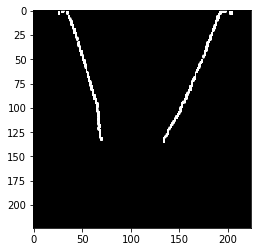

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

f = h5py.File("//Users/atsaris/mygit_repos/ml_service/datasets/HDF5Images/train_small.h5",'r')
images = np.array(f['data'])
labels = np.array(f['label'])
labels = labels.reshape(labels.shape[0])

images1 = images[:, 0, :, :]
images2 = images[:, 1, :, :]
images1 = images1.reshape(images1.shape[0], images1.shape[1], images1.shape[2], 1).astype('float32')
images2 = images2.reshape(images2.shape[0], images2.shape[1], images2.shape[2], 1).astype('float32')
images = np.concatenate((images1, images2), axis=2)

sess = tf.Session()
with sess.as_default():
    images_tf = tf.image.grayscale_to_rgb(images)
    images_tf = tf.image.resize_images(images_tf, [224,224])
    images = images_tf.eval()

f.close()
    
print(images.shape)
plt.imshow(images[0])

feature_list = []
with tf.Session() as sess:
    #for chunk in tqdm(chunks(images,50)):
    for chunk in chunks(images,50):
        result= sess.run([features],feed_dict={image_tensors:chunk})
        feature_list.extend(result[0])
        
feature_results = np.array(feature_list)
print(feature_results.shape)

In [6]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras import optimizers

FC_SIZE = 1024
NUM_CLASSES = 5

model = Sequential()
model.add(Dropout(0.2, input_shape=(1, 1, 2048,)))
model.add(Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,)))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='sigmoid', input_dim=FC_SIZE))

model.compile(optimizer=optimizers.SGD(lr=1e-4,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

onehot_labels = np_utils.to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(feature_results, onehot_labels, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7500, 1, 1, 2048) (2500, 1, 1, 2048) (7500, 5) (2500, 5)


In [12]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
7500/7500 [==============================] - 2s 250us/step - loss: 0.3732 - acc: 0.8359
Epoch 2/100
7500/7500 [==============================] - 2s 254us/step - loss: 0.3710 - acc: 0.8373
Epoch 3/100
7500/7500 [==============================] - 2s 245us/step - loss: 0.3696 - acc: 0.8393
Epoch 4/100
7500/7500 [==============================] - 2s 262us/step - loss: 0.3677 - acc: 0.8371
Epoch 5/100
7500/7500 [==============================] - 2s 291us/step - loss: 0.3680 - acc: 0.8383
Epoch 6/100
7500/7500 [==============================] - 2s 293us/step - loss: 0.3659 - acc: 0.8394
Epoch 7/100
7500/7500 [==============================] - 2s 296us/step - loss: 0.3656 - acc: 0.8413
Epoch 8/100
7500/7500 [==============================] - 2s 289us/step - loss: 0.3640 - acc: 0.8399
Epoch 9/100
7500/7500 [==============================] - 2s 297us/step - loss: 0.3638 - acc: 0.8415
Epoch 10/100
7500/7500 [==============================] - 2s 305us/step - loss: 0.3628 - acc: 0.8413

7500/7500 [==============================] - 2s 243us/step - loss: 0.3307 - acc: 0.8561
Epoch 83/100
7500/7500 [==============================] - 2s 238us/step - loss: 0.3311 - acc: 0.8556
Epoch 84/100
7500/7500 [==============================] - 2s 271us/step - loss: 0.3319 - acc: 0.8551
Epoch 85/100
7500/7500 [==============================] - 2s 321us/step - loss: 0.3313 - acc: 0.8550
Epoch 86/100
7500/7500 [==============================] - 2s 289us/step - loss: 0.3297 - acc: 0.8565
Epoch 87/100
7500/7500 [==============================] - 2s 318us/step - loss: 0.3309 - acc: 0.8550
Epoch 88/100
7500/7500 [==============================] - 2s 311us/step - loss: 0.3297 - acc: 0.8569
Epoch 89/100
7500/7500 [==============================] - 2s 313us/step - loss: 0.3305 - acc: 0.8557
Epoch 90/100
7500/7500 [==============================] - 2s 313us/step - loss: 0.3304 - acc: 0.8556
Epoch 91/100
7500/7500 [==============================] - 2s 310us/step - loss: 0.3289 - acc: 0.8558
Epo

In [13]:
from numpy import argmax

y_probs = model.predict(X_test)
y_prob_max = np.argmax(y_probs, 1)
y_test_max = np.argmax(y_test, 1)
print(y_probs)
print(y_prob_max)
print(y_test_max)

[[0.01647069 0.9733935  0.04283217 0.00255974 0.02058058]
 [0.15101701 0.16137546 0.01384765 0.5893849  0.16406521]
 [0.835593   0.0995993  0.02503943 0.11049128 0.02657235]
 ...
 [0.18449202 0.6125358  0.02585943 0.03604557 0.08427055]
 [0.11724138 0.15383503 0.01250111 0.6015305  0.23236081]
 [0.23405686 0.13941704 0.02067658 0.5516338  0.07988331]]
[1 3 0 ... 1 3 3]
[1 3 3 ... 1 3 3]


Accuracy 0.62
Precision [0.62128713 0.75049116 0.27160494 0.56255969 1.        ]
Recall [0.69432918 0.59133127 0.14379085 0.75609756 0.27638191]
F1 [0.65578054 0.66147186 0.18803419 0.64512596 0.43307087]
Confusion Matrix [[502, 18, 24, 179, 0], [99, 382, 6, 159, 0], [63, 23, 22, 45, 0], [139, 22, 29, 589, 0], [5, 64, 0, 75, 55]]


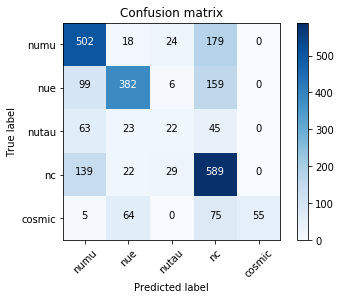

In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib
from matplotlib import pyplot as plt

# compute a bunch of classification metrics 
def classification_metrics(y_true, y_pred, y_prob):
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred, average=None)
    cm_dict['Recall'] =  recall_score(y_true, y_pred, average=None)
    cm_dict['F1'] =  f1_score(y_true, y_pred, average=None) 
    #cm_dict['AUC'] = roc_auc_score(y_true, y_prob[:,0])
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    New BSD License - see appendix
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_dict = classification_metrics(y_test_max, y_prob_max, y_probs)
for m in cm_dict:
    print(m, cm_dict[m])
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['numu','nue','nutau','nc','cosmic'], normalize=False)

In [15]:
featurizer.cleanup_remote_service()